<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cross-validation</a></span></li><li><span><a href="#Train-model-over-full-train-set" data-toc-modified-id="Train-model-over-full-train-set-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train model over full train set</a></span></li></ul></li><li><span><a href="#Predict-over-test-set" data-toc-modified-id="Predict-over-test-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict over test set</a></span></li><li><span><a href="#Submit-predictions" data-toc-modified-id="Submit-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Submit predictions</a></span></li></ul></div>

----

**<big>ESA Datalabs Ariel Hackathon</big>**

Modelling starter code

----

----

# Imports

In [1]:
import gc, requests
from sklearn.linear_model import Lasso, Ridge
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

import sys
sys.path.append('esac-hackathon-starter-code-dev')
from adc21 import *

---

**Load dataset**

In [2]:
# Please adjust the below path with your team's workspace, e.g. '/media/team_workspaces/MYTEAMNAME/'
DATA_PATH = '/media/team_workspaces/CoRoT-7-b/'

In [3]:
%%time
DATA = load_dataset(DATA_PATH + 'ADC21esac_train.pkl')
#DATA = load_dataset(DATA_PATH + 'ADC21esac_test.pkl')
print(type(DATA))

<class 'adc21.data.dataset'>
CPU times: user 1.4 s, sys: 5.78 s, total: 7.18 s
Wall time: 1min 30s


----

----

## Cleaning (ensuring that there are no missing values, Nan's or 0 or similar)

In [4]:
# Check the type of DATA.X and inspect its content
print(type(DATA.X))

# If DATA.X is a dictionary of numpy arrays or lists
for key, value in DATA.X.items():
    # Check if the value is a numpy array or list
    if isinstance(value, (np.ndarray, list)):
        # Check for missing values (NaNs)
        missing_values = np.any(np.isnan(value)).sum()
        if missing_values > 0:
            print(f"Missing values in column {key}: {missing_values}")

<class 'dict'>


No missing values

# Data preparation

You are free to train your ML models over the raw data, or over data pre-processed in any way you choose.

We offer below a possible way to prepare the data for modelling.

This data preparation pipeline is also in use at the **https://ariel-lightcurve-challenge.mlanalytics.ai/** website. You are encouraged to use the website to explore the dataset, and the impact of different transformations.

***Parameters of the data pre-processing pipeline***:

**WINDOW_RADIUS**
* Improve estimate of observation at time t by taking the mean over all values observed in the [t-r, t+r] time window, where r is the chosen radius. Process is applied for all time instants, of all wavelength channels.

**AGGR_NUM_OBS**
* We have the chance to observe the exoplanet for up to 10 of its \"years\", 10 different transits in front of its star (in this dataset). We know enough about the planet's orbit to know the point of a transit that should match the equivalent point of a different transit. When taking the mean to estimate the light curve value at time t, it is then best to consider also the matching observations of up to how many different transits?

**MIRROR_STACKING**
* An ideal observation of a planet's transit, with no imprecision in the measurements, would produce a smooth light curve, symmetrical around the point of maximum dip. What we know of the planet's orbit allows us to estimate when is that point reached. In this dataset, it's at the t=150 instant. When estimating the true value at t=100, for instance, the measurements at t=200 are then also informative. Choosing this option, the time-symmetrical measurements are then also included when calculating the mean. By doing so, observe how the light curves become symmetrical. For training the AI model, it is then enough to consider just half the curve, as it would be redundant to see same values again on the other side of t=150.

**MEAN_TYPE**
* The settings above define the set of values we'll consider as relevant to the estimation of the true value at a given time instant. What is then the best way to aggregate all those separate measurements? We'll be using what's known as a "[generalized mean](https://en.wikipedia.org/wiki/Generalized_mean)" for that. This equation has a single parameter, p. For p=1 it becomes the well known arithmetic mean. Different settings will favour either the smaller (p<0) or larger values under aggregation (p>0). The plots may show imperceptible differences, but the AI model will be sensitive to it!

**GRID_PTS_NUM**
* How many different things should the AI model consider at once? You want to make the learning problem as simple as possible, but not so simple that the AI is not exposed to important information, and is then unable to perform well. The AI won't be seeing the full light curve – it contains 300×55=16,500 measurements for just one transit! Instead, we perform aggregations at just a few carefully chosen time steps, and have the AI learn over just those. This parameter then controls the number of different variables you give to the AI model, and so the complexity of the learning problem.

**GRID_PTS_SPACING**
* Is it better to focus around the t=150 instant, or does the AI need to consider also the slope down from 1.0 relative brightness? This parameter controls the spacing, in minutes, between the grid points chosen in the previous setting. It determines the kind of information the AI will consider when learning how to extract the spectrum from the light curve.

In [5]:
# configure the desired data pre-processing pipeline

data_setup = dict(
    WINDOW_RADIUS    = 14,
    AGGR_NUM_OBS     = 10,
    MIRROR_STACKING  = True,
    MEAN_TYPE_P      = -2,
    
    GRID_PTS_NUM     = 10,
    GRID_PTS_SPACING = 5,
    )


setup_summary(data_setup)
data_setup

With these settings, a star has its observations transformed into a 611-dimensional representation: 10+1 grid points × 55 wavelength channels + 6 stellar/planet parameters.
Each grid point aggregates with a p=-2 a total of 580 values: a time window 2×14+1 minutes wide × 10 planetary transits × 2 time symmetrical observations.


{'WINDOW_RADIUS': 14,
 'AGGR_NUM_OBS': 10,
 'MIRROR_STACKING': True,
 'MEAN_TYPE_P': -2,
 'GRID_PTS_NUM': 10,
 'GRID_PTS_SPACING': 5}

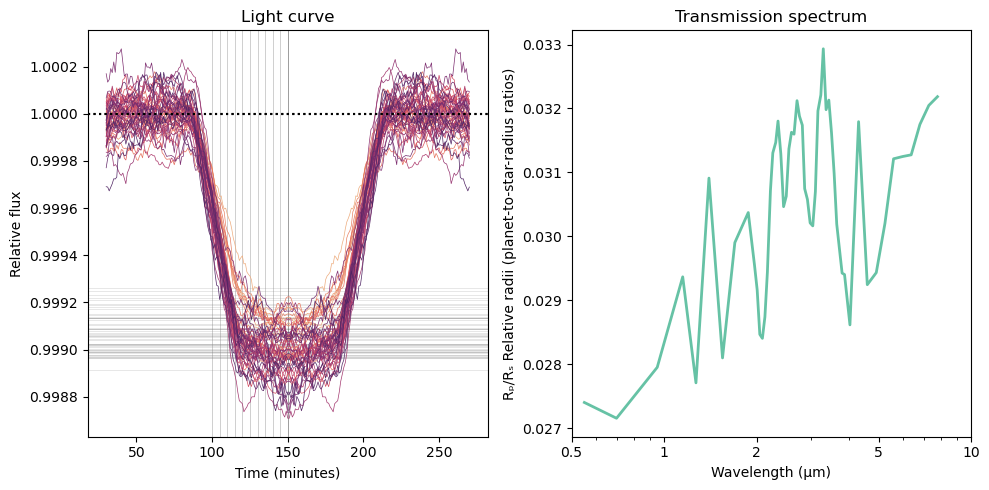

In [6]:
# Visualization of how the data pre-processing defined above transforms a given planet's observations
visualize_setup(DATA, data_setup, planet_id=1759)

\
To transform the whole dataset using the `data_setup` defined above, first call `configure_pipeline()`, and then `prepare_data()`.

In [7]:
X_pipeline = configure_pipeline(**data_setup)
#X_pipeline

In [8]:
%%time
data = prepare_data(DATA, X_pipeline)

functools.partial(<function X__set_to__obs_encodings at 0x7f7c2a2accc0>, agg_stellar=False, agg_photon=10, agg=-2, window_radius=14, grid=(100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150), mirror_stacking=True)


functools.partial(<function X__stack_with__par at 0x7f7c2a2af100>, par_var='X_par')
CPU times: user 7.89 s, sys: 1.16 s, total: 9.05 s
Wall time: 9.13 s


In [9]:
type(data), data.X.dtype, data.y.dtype
print(data.X)

[[3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 5.2582700e-02
  5.2138746e-02 5.2403864e-02]
 [3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 5.6493632e-02
  5.7339273e-02 5.9075475e-02]
 [3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 6.1079085e-02
  5.9922475e-02 6.0364481e-02]
 ...
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 2.0040361e-02
  0.0000000e+00 0.0000000e+00]
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 6.5082140e-02
  5.5472597e-02 4.5016646e-02]
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 6.9040880e-02
  6.1910231e-02 6.6577017e-02]]


## Check if missing values after data has been prepared

In [10]:
# Check the type of data.X and inspect its content
print(type(data.X))

if isinstance(data.X, np.ndarray):  # If it's a numpy array
    # Check for missing values in each column (axis=0 for columns)
    missing_values = np.isnan(data.X).sum(axis=0)
    for i, value in enumerate(missing_values):
        if value > 0:
            print(f"Missing values in column {i}: {value}")

<class 'numpy.ndarray'>


In [11]:
data.X

array([[3.6674199e+03, 5.0000000e+00, 4.3950000e-01, ..., 5.2582700e-02,
        5.2138746e-02, 5.2403864e-02],
       [3.6674199e+03, 5.0000000e+00, 4.3950000e-01, ..., 5.6493632e-02,
        5.7339273e-02, 5.9075475e-02],
       [3.6674199e+03, 5.0000000e+00, 4.3950000e-01, ..., 6.1079085e-02,
        5.9922475e-02, 6.0364481e-02],
       ...,
       [4.7310000e+03, 4.5000000e+00, 6.9000000e-01, ..., 2.0040361e-02,
        0.0000000e+00, 0.0000000e+00],
       [4.7310000e+03, 4.5000000e+00, 6.9000000e-01, ..., 6.5082140e-02,
        5.5472597e-02, 4.5016646e-02],
       [4.7310000e+03, 4.5000000e+00, 6.9000000e-01, ..., 6.9040880e-02,
        6.1910231e-02, 6.6577017e-02]], dtype=float32)

In [12]:
data.y

array([[0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       [0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       [0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       ...,
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ],
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ],
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ]], dtype=float32)

In [13]:
data.X.shape

(10000, 611)

In [14]:
data.y.shape

(10000, 55)

\
**At this point you have a defined ML problem: given `data.X`, predict `data.y`.**

\
If you don't need the raw data anymore, you can remove it from memory.

In [15]:
del DATA
del data.X_obs

gc.collect()

17183

----

# Modelling

Let's start simple, with a linear model ([sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).

In [16]:
#model_class = Ridge

#model_args  = dict(alpha=100)

# Use Lasso Regression instead of Ridge
model_class = Lasso
model_args = dict(alpha=0.00005, tol = 0.01)  # Adjust alpha for better regularization

## Cross-validation

Depending on how you prepare the data, you'll most likely end up with different samples belonging to the same planet. Those samples will have the same star/planet parameters, the same prediction targets, and observations subjected to different noise instances.

When cross-validating your modelling setup, you must ensure you use something like [sklearn.model_selection.GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html), so the data split will happen at a planet-level, rather than sample-level. Otherwise, if the same planet ends up being present in both the train and validation folds, you'll obtain optimistic performance metrics.

We provide a `cross_validate_setup()` function that works over `adc21.data_pipeline.data_container` objects, and implements k-fold cross validation with splits at planet level. It takes as argument an `init_model` function that creates instances of your chosen model class. Those objects are expected to implement a scikit-learn like interface with `.fit()` and `.predict()` methods. The cross validation function also handles data standardization into 0 mean and 1 standard deviation (defined over train-fold, applied over validation fold).

In [17]:
# convenience function that creates an instance of the chosen model_class, parameterized with the chosen model_args
init_model = lambda : model_class(**model_args)

In [18]:
help(cross_validate_setup)

Help on function cross_validate_setup in module adc21.evaluate:

cross_validate_setup(data, init_model, n_splits=10, split_seed=0, standardize=True, prefit_transform=None, y_encode=None, y_decode=None, fit_err_track=False, verbose=True, **fit_args)
    Cross-validate a modelling setup.
    
    Returns results as a dictionary, where each key maps to a list of results
    per train/validation fold:
    
    ```python
    # Initialization of the CV results dictionary:
    cv_res = dict(
            test_ids   = [],  # ids of planets that were included in the test-fold used to evaluate this model.
            data_cfg   = [],  # parameters configuring processing of data sent to each model (standardization parameters)
            models     = [],  # the trained models
            y_true     = [],  # the prediction targets of samples on the test-fold
            y_pred     = [],  # the y_pred of each model on its test-fold
            y_pred_agg = [],  # test-fold predictions aggregated at 

In [19]:
%%time
cv_res = cross_validate_setup(data, init_model, n_splits=10, standardize=True)

CPU times: user 29min 43s, sys: 1.47 s, total: 29min 44s
Wall time: 9min 53s


The scoring functions provided in the `adc21` module implement various regression metrics. Evaluation tables contain:

* `R^2` - [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
* `MSE` - [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
* `RMSE` - Root Mean Squared Error, `np.sqrt(MSE)`
* `RMSPE` - Root Mean Squared Percentage Error (RMSPE), `RMSPE = np.sqrt(((y_pred / y_true - 1) ** 2).mean())`
* `MAE` - [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)
* `MedianAE` - [median_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html)
* `Score, w: none` - Scaled MAE, with optimum at 10,000.
  * Implemented as `1e4 - MAE * 1e6`
* **`Score, w: 2*radii`** - Scaled and weighted MAE, with optimum at 10,000. This is the score you'll be evaluated on. Read  more about it at the [Hackathon Details](https://www.ariel-datachallenge.space/esa-datalabs25/details) page.
  * Implemented as `1e4 - 2 * (y_true * np.abs(y_pred - y_true)).mean() * 1e6`

In [20]:
# Evaluations per validation fold
fold_evals = pd.concat(cv_res['evals'], axis=1)
fold_evals

,0,1,2,3,4,5,6,7,8,9
R^2,0.960997,0.985789,0.981560,0.988497,0.992788,0.972693,0.975185,0.982710,0.976809,0.970505
MSE,0.000098,0.000030,0.000015,0.000016,0.000007,0.000047,0.000029,0.000023,0.000053,0.000039
RMSE,0.009917,0.005519,0.003815,0.003988,0.002666,0.006851,0.005391,0.004817,0.007247,0.006250
RMSPE,0.131626,0.092611,0.107876,0.088249,0.085335,0.114467,0.095324,0.097041,0.083459,0.117023
MAE,0.003591,0.002578,0.002106,0.002192,0.001789,0.002798,0.002457,0.002416,0.002938,0.002837
MedianAE,0.001206,0.001124,0.001231,0.001179,0.001174,0.001152,0.001257,0.001344,0.001142,0.001256
"Score, w: none",6409.233194,7422.340559,7894.183034,7808.408458,8210.984166,7202.314436,7543.400154,7584.006051,7061.810922,7163.173510
"Score, w: 2*radii",9276.707065,9548.826570,9787.751425,9683.011236,9832.834263,9563.062913,9663.593742,9648.932921,9306.242622,9569.035223


In [21]:
# Evaluations per validation fold (average)
print(fold_evals.agg(['mean', 'std'], axis=1))

                          mean         std
R^2                   0.978753    0.009437
MSE                   0.000036    0.000026
RMSE                  0.005646    0.002065
RMSPE                 0.101301    0.015834
MAE                   0.002570    0.000506
MedianAE              0.001207    0.000067
Score, w: none     7429.985448  506.161634
Score, w: 2*radii  9587.999798  181.691254


In [22]:
# Evaluation of predictions aggregated across planet's stellar/photon noise instances
print(pd.concat(cv_res['evals_agg'], axis=1).agg(['mean', 'std'], axis=1))

                          mean         std
R^2                   0.980386    0.009910
MSE                   0.000034    0.000026
RMSE                  0.005406    0.002184
RMSPE                 0.082164    0.020485
MAE                   0.002234    0.000530
MedianAE              0.000966    0.000071
Score, w: none     7766.165040  529.706637
Score, w: 2*radii  9612.185628  182.447477


In [23]:
# target & prediction for all samples, from the one time they were in the validation fold
y_true = np.vstack(cv_res['y_true'])
y_pred = np.vstack(cv_res['y_pred'])

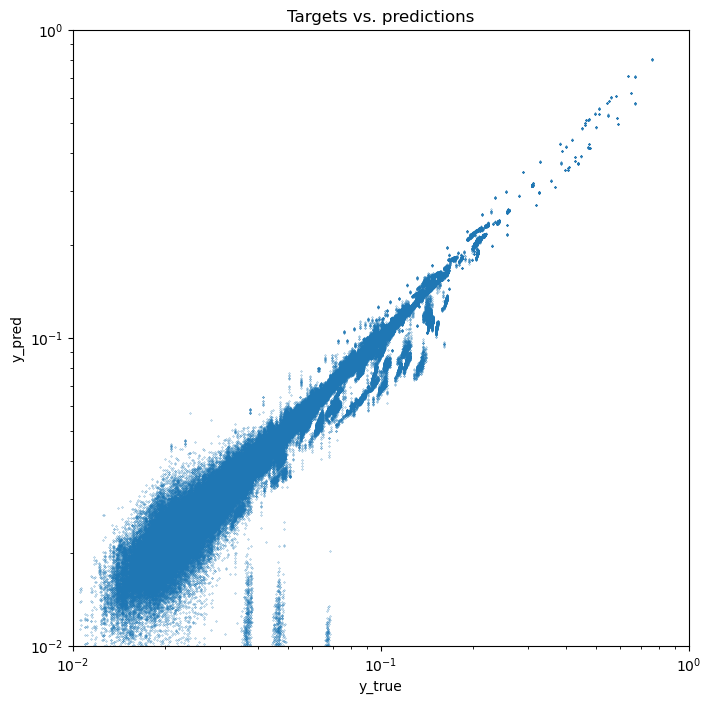

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, s=0.05)
plt.xlabel('y_true')
plt.ylabel('y_pred');
plt.gca().set_aspect('equal', 'box')
plt.xlim(1e-2, 1e-0)
plt.ylim(1e-2, 1e-0)
plt.yscale('log')
plt.xscale('log')
plt.title('Targets vs. predictions');

----

## Train model over full train set

In [25]:
# standardize data to 0 mean and 1 standard deviation
(X_st, x, X_st_params) = standardizer(data.X)

X_st.mean(), X_st.std()

(3.3504404e-07, 0.9999999)

In [26]:
y_true = data.y

In [27]:
model = init_model()

In [28]:
model.fit(X_st, y_true)

Lasso(alpha=0.0001, tol=0.005)

In [29]:
y_pred = model.predict(X_st)

In [30]:
# train set performance, at sample level
score(y_true, y_pred)

[ Scoring with y_true.shape: (10000, 55) ]


R^2                     0.980201
MSE                     0.000032
RMSE                    0.005614
RMSPE                   0.099050
MAE                     0.002462
MedianAE                0.001181
Score, w: none       7537.893709
Score, w: 2*radii    9629.298865
dtype: float64

In [31]:
# train set performance, when predictions are aggregated at planet level, across stellar_spot/photon noise instances
score(*y_aggregate(data, y_true, y_pred))

[ Scoring with y_true.shape: (1000, 55) ]


R^2                     0.981530
MSE                     0.000029
RMSE                    0.005422
RMSPE                   0.081259
MAE                     0.002129
MedianAE                0.000948
Score, w: none       7870.558174
Score, w: 2*radii    9653.490726
dtype: float64

-----

-----

# Predict over test set

In [32]:
%%time
TEST_DATA = load_dataset(DATA_PATH + 'ADC21esac_test.pkl')

CPU times: user 1.15 s, sys: 1.3 s, total: 2.45 s
Wall time: 45.2 s


In [33]:
data_setup

{'WINDOW_RADIUS': 14,
 'AGGR_NUM_OBS': 10,
 'MIRROR_STACKING': True,
 'MEAN_TYPE_P': -2,
 'GRID_PTS_NUM': 10,
 'GRID_PTS_SPACING': 5}

\
Encode the test set using the same data pre-processing pipeline thas was used over the train set.

In [34]:
%%time
#X_pipeline = configure_pipeline(**data_setup)
test_data = prepare_data(TEST_DATA, X_pipeline)

functools.partial(<function X__set_to__obs_encodings at 0x7f7c2a2accc0>, agg_stellar=False, agg_photon=10, agg=-2, window_radius=14, grid=(100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150), mirror_stacking=True)


functools.partial(<function X__stack_with__par at 0x7f7c2a2af100>, par_var='X_par')
CPU times: user 4.07 s, sys: 9.97 ms, total: 4.08 s
Wall time: 4.1 s


In [35]:
test_data.X.shape

(5120, 611)

In [36]:
del TEST_DATA
del test_data.X_obs

gc.collect()

0

\
Use the trained model to generate predictions over the test set.

In [37]:
# standardize the data, using the parameters that were defined over the train set
test_X_st = standardizer(test_data.X, avg_std=X_st_params)[0]

In [38]:
test_y_pred = model.predict(test_X_st)

In [39]:
test_y_pred.shape

(5120, 55)

-----

-----

# Submit predictions

The data pre-processing pipeline may aggregate observations at different levels:
* aggregations across photon noise instances leave us with 1 sample per planet / stellar_spot combination (10 samples per planet).
* aggregations across stellar spot instances, and their photon noise instances leave us with 1 sample per planet.

Below, in `ix_all` are the indices of all samples in the test set. Submissions must provide one prediction for each of those samples. Encoding left us with the `ix_enc` indices. If they differ, we must then propagate predictions to the other samples of the same planet / stellar_spot.

In [40]:
ix_all = test_data.X_par_all[OBSERV_INDEX].set_index(OBSERV_INDEX, append=True).index
ix_enc = test_data.X_par[    OBSERV_INDEX].set_index(OBSERV_INDEX, append=True).index

In [41]:
# Indexed DataFrame version of the predictions matrix

test_y_pred_df = pd.DataFrame(
    test_y_pred,
    index=ix_enc,
    columns=[f'w{i+1}' for i in range(55)])

test_y_pred_df

,,,,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w46,w47,w48,w49,w50,w51,w52,w53,w54,w55
index,planet,stellar_spot,photon,,,,,,,,,,,,,,,,,,,,,
0003_01_01.txt,3,1,1,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
0003_02_01.txt,3,2,1,0.040261,0.040052,0.040833,0.041751,0.040866,0.041858,0.041246,0.041263,0.040782,0.040641,...,0.048242,0.045017,0.040730,0.039839,0.039399,0.041267,0.041665,0.042676,0.042776,0.040426
0003_03_01.txt,3,3,1,0.038997,0.038783,0.038793,0.039458,0.038509,0.040861,0.038913,0.039226,0.040522,0.040256,...,0.044839,0.040466,0.041650,0.041911,0.041596,0.042751,0.042972,0.043296,0.044019,0.041757
0003_04_01.txt,3,4,1,0.037282,0.037118,0.037290,0.038196,0.037291,0.039604,0.038019,0.038105,0.039004,0.038794,...,0.048325,0.042965,0.039067,0.039013,0.040007,0.040084,0.040055,0.039213,0.040891,0.039108
0003_05_01.txt,3,5,1,0.037223,0.036969,0.038400,0.039296,0.038522,0.040360,0.039605,0.039277,0.039582,0.039450,...,0.039028,0.036059,0.037620,0.041460,0.042822,0.039535,0.039188,0.039834,0.039019,0.042186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381_06_01.txt,4381,6,1,0.123386,0.123068,0.124455,0.126372,0.125139,0.129447,0.126864,0.127494,0.129460,0.129188,...,0.131322,0.130366,0.129631,0.129865,0.131179,0.130831,0.130927,0.132746,0.132861,0.133651
4381_07_01.txt,4381,7,1,0.123015,0.122680,0.124097,0.125983,0.124834,0.129130,0.126516,0.127412,0.129136,0.128897,...,0.131074,0.131148,0.130502,0.129035,0.130126,0.130852,0.130851,0.131917,0.132984,0.132682
4381_08_01.txt,4381,8,1,0.123829,0.123503,0.125136,0.127310,0.126066,0.130541,0.127930,0.128844,0.130790,0.130473,...,0.130874,0.131865,0.131892,0.130639,0.131664,0.132590,0.132711,0.134055,0.135508,0.134674


Propagate predictions across samples of the same planet / stellar_spot.

In [42]:
test_y_pred_df = test_y_pred_df.reindex(ix_all).fillna(method='ffill')
test_y_pred_df

,,,,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w46,w47,w48,w49,w50,w51,w52,w53,w54,w55
,planet,stellar_spot,photon,,,,,,,,,,,,,,,,,,,,,
0003_01_01.txt,3,1,1,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
0003_01_02.txt,3,1,2,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
0003_01_03.txt,3,1,3,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
0003_01_04.txt,3,1,4,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
0003_01_05.txt,3,1,5,0.041151,0.040986,0.041304,0.042138,0.041128,0.042704,0.041072,0.041920,0.042184,0.041952,...,0.048624,0.044855,0.043144,0.041193,0.040961,0.044162,0.044300,0.044912,0.044774,0.042340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381_10_06.txt,4381,10,6,0.124101,0.123741,0.125314,0.127458,0.126207,0.130416,0.128067,0.129033,0.130562,0.130220,...,0.131700,0.131317,0.131296,0.131115,0.132027,0.132094,0.132046,0.133784,0.134470,0.136155
4381_10_07.txt,4381,10,7,0.124101,0.123741,0.125314,0.127458,0.126207,0.130416,0.128067,0.129033,0.130562,0.130220,...,0.131700,0.131317,0.131296,0.131115,0.132027,0.132094,0.132046,0.133784,0.134470,0.136155
4381_10_08.txt,4381,10,8,0.124101,0.123741,0.125314,0.127458,0.126207,0.130416,0.128067,0.129033,0.130562,0.130220,...,0.131700,0.131317,0.131296,0.131115,0.132027,0.132094,0.132046,0.133784,0.134470,0.136155


\
**Submit**

In [43]:
s_path = 'submissions/'
os.makedirs(s_path, exist_ok=True)

s_file = str(pd.Timestamp('now').round('s')).replace(':', '.') + '.csv'
s_file

'2025-01-17 10.17.55.csv'

Write predictions to the hard drive.

In [44]:
submission = test_y_pred_df.reset_index(level=OBSERV_INDEX, drop=True).rename_axis(index='files')

In [45]:
submission.to_csv(s_path + s_file)

Submit predictions using the REST API.

In [46]:
# Enter your team's identifiers
team_id = {
    "team_no": "3",
    "team_name": "CoRoT-7-b",
    "secret_key": "2006",
    }

In [47]:
files = {"file": (s_file, submission.to_csv(), "text/csv")}

response = requests.post(
    "https://www.ariel-datachallenge.space/api/score/calculate/",
    data=team_id, files=files)

print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    response_json = response.json()
    print(f"Successful submission by '{team_id['team_name']}', " +
          f"with a public leaderboard score of {response_json['score']}")
else:
    print(f"Submission failure:", response.json())

Status Code: 200
Successful submission by 'CoRoT-7-b', with a public leaderboard score of 9051.015116194068


These are the error codes you may come across when submitting:

    Wrong file type : File is not in .csv format
    File processing failed : The .csv file is not formatted correctly
    Invalid secret code : Typo in secret code or wrong code
    Invalid data format : The file has non-numeric values
    Wrong data format : The num of rows or column is not as expected
    Invalid Submission : Empty file submitted

-----

-----